In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit import DataStructs

DATAPATH = "../data"
FIGUREPATH = "../figures"

/tmp/ipykernel_71729/1575956909.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Descriptors

The authors use a combination of physiocochemical descriptors as well as ECPFs. The physicochemical descriptors are scaled (mean = 0, variance = 1)

In [2]:
### CODE TO CONVERT TO DESCRIPTORS ###
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import QED
from sklearn.preprocessing import StandardScaler

# Function to calculate ECFP descriptors
def ecfp_calculation(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    bit_info_list = []
    bit_info = {}
    fps = []
    for mol in mols:
        fps.append(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024, bitInfo=bit_info))
        bit_info_list.append(bit_info.copy())
    arr_list = [np.zeros((0,), dtype=np.int8) for _ in range(len(fps))]
    for i, bit in enumerate(fps):
        DataStructs.ConvertToNumpyArray(bit, arr_list[i])
    ecfps = np.stack([i.tolist() for i in arr_list])
    df = pd.DataFrame(ecfps.astype(np.float32))
    return df

# Function to calculate QED descriptors
def qed_calculation(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    qe = [QED.properties(mol) for mol in mols]
    qe_df = pd.DataFrame(qe)
    return qe_df

# Function to scale QED descriptors
def scale_qed(df):
    scaler = StandardScaler()
    scaled_array = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns)
    return scaled_df


# Function to preprocess the data
def preprocess_data(df):
    smiles = df['smiles'].tolist()
    
    # Calculate ECFP descriptors
    ecfp_df = ecfp_calculation(smiles)
    
    # Calculate QED descriptors
    qed_df = qed_calculation(smiles)
    
    # Scale the QED descriptors
    scaled_qed_df = scale_qed(qed_df)
    
    # Concatenate the descriptor dataframes
    processed_df = pd.concat([ecfp_df, scaled_qed_df], axis=1)

    # Add toxicity column
    processed_df['toxicity'] = df['toxicity']
    
    return processed_df

# Load your dataset
test_dataset_filepath = os.path.join(DATAPATH, 'test.csv')
test_df = pd.read_csv(test_dataset_filepath)

train_dataset_filepath = os.path.join(DATAPATH, 'train.csv')
train_df = pd.read_csv(train_dataset_filepath)

# Preprocess the data
processed_test_data = preprocess_data(test_df)
processed_train_data = preprocess_data(train_df)


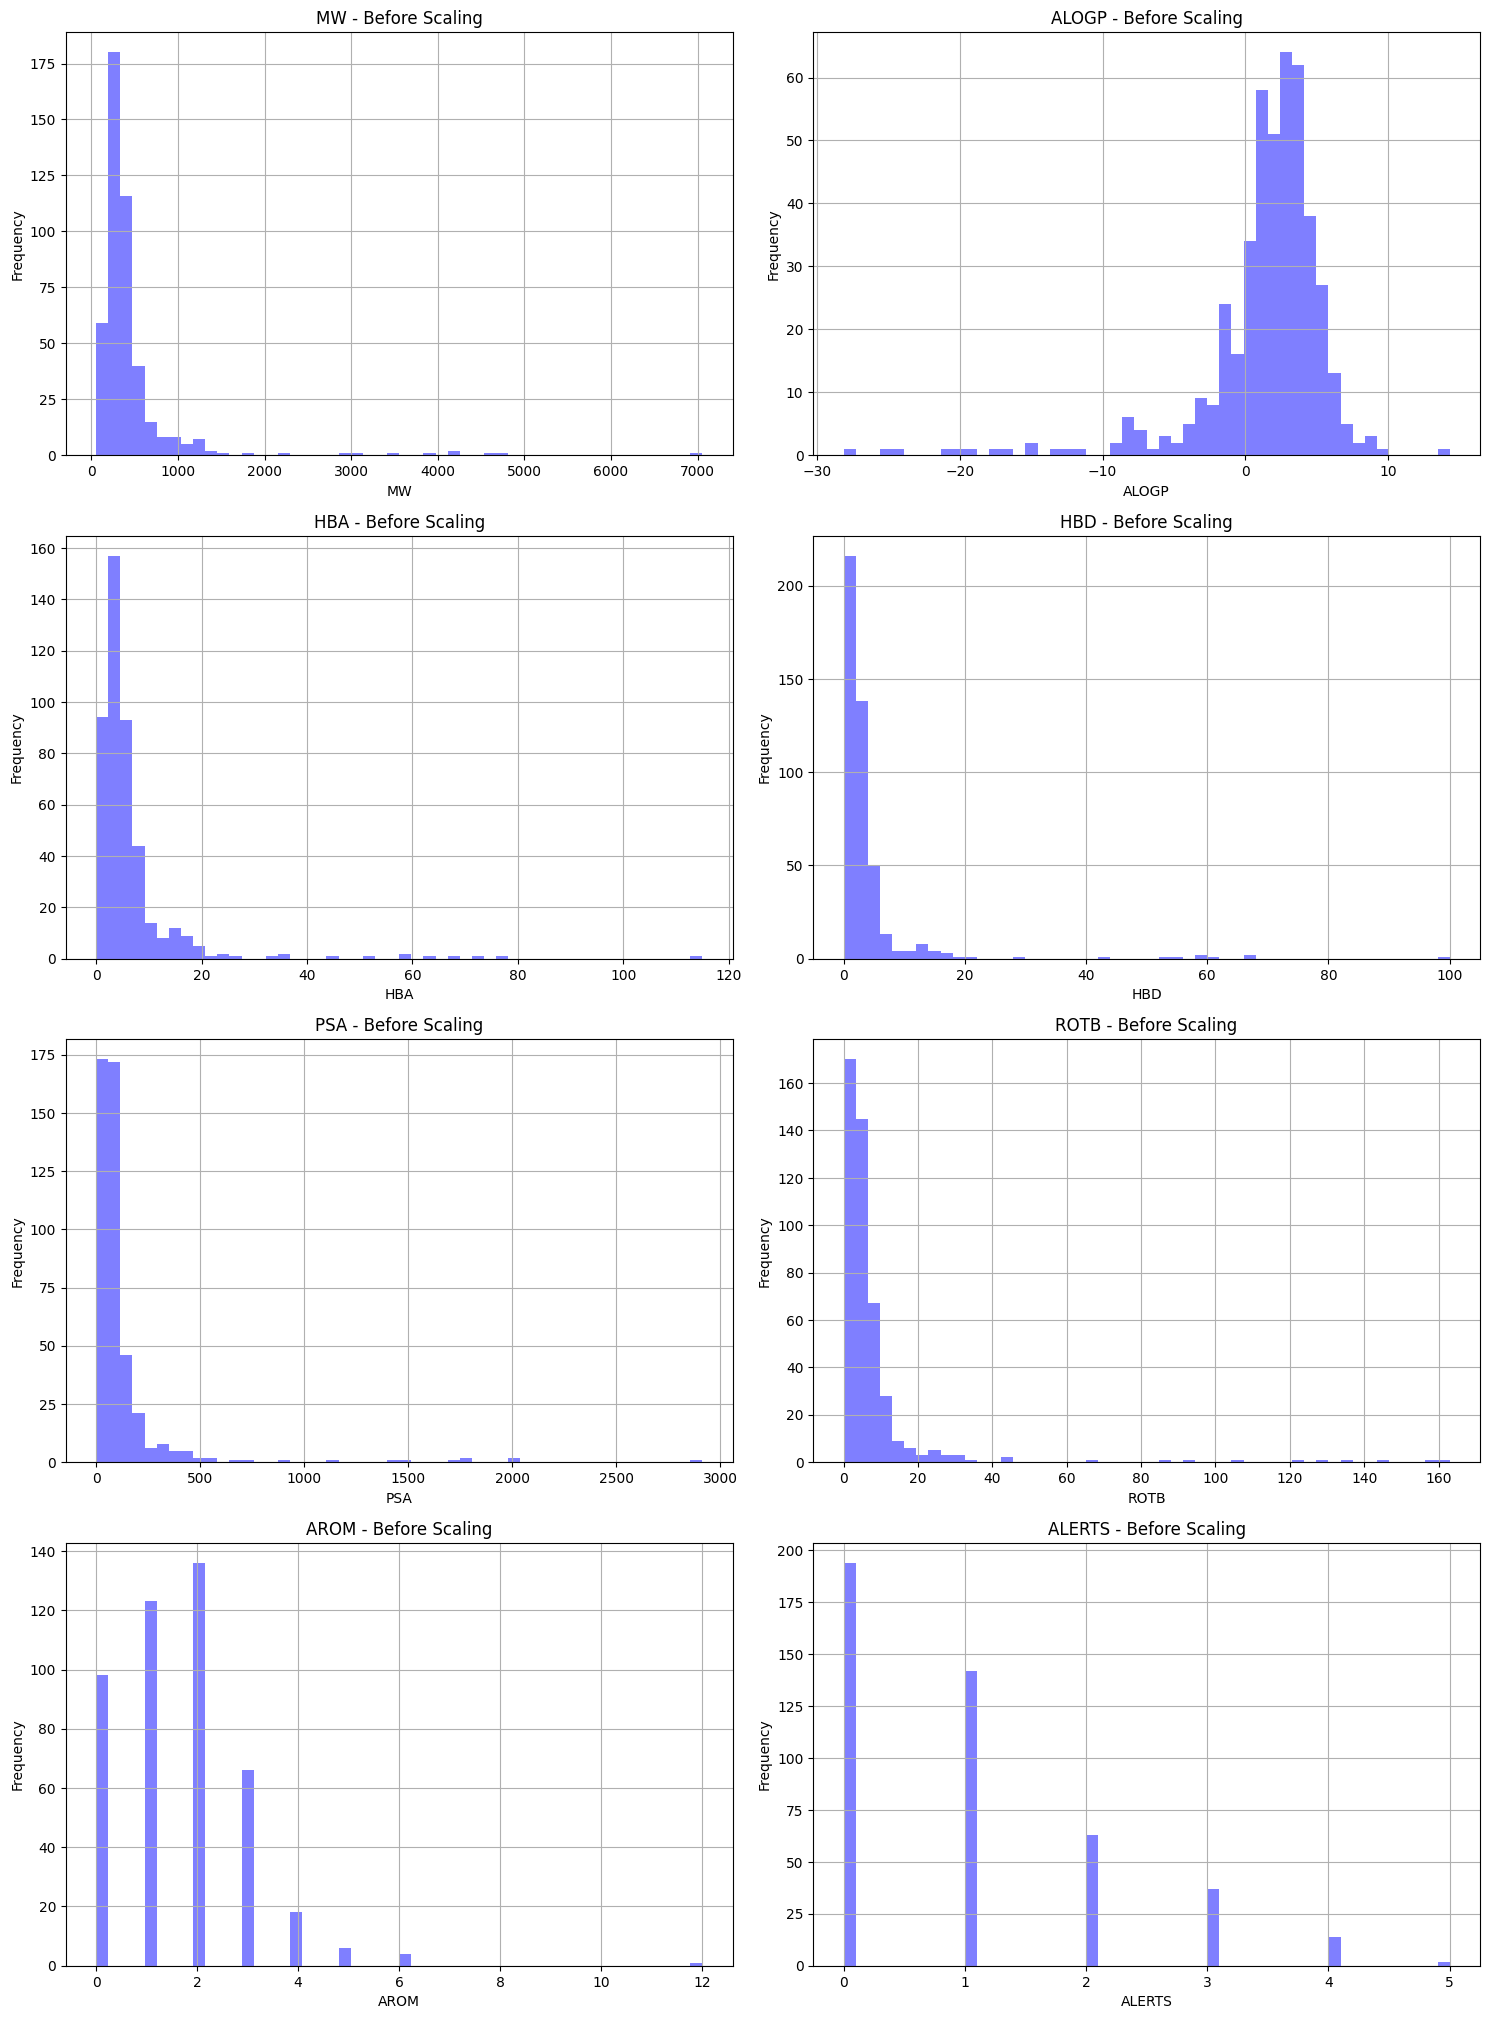

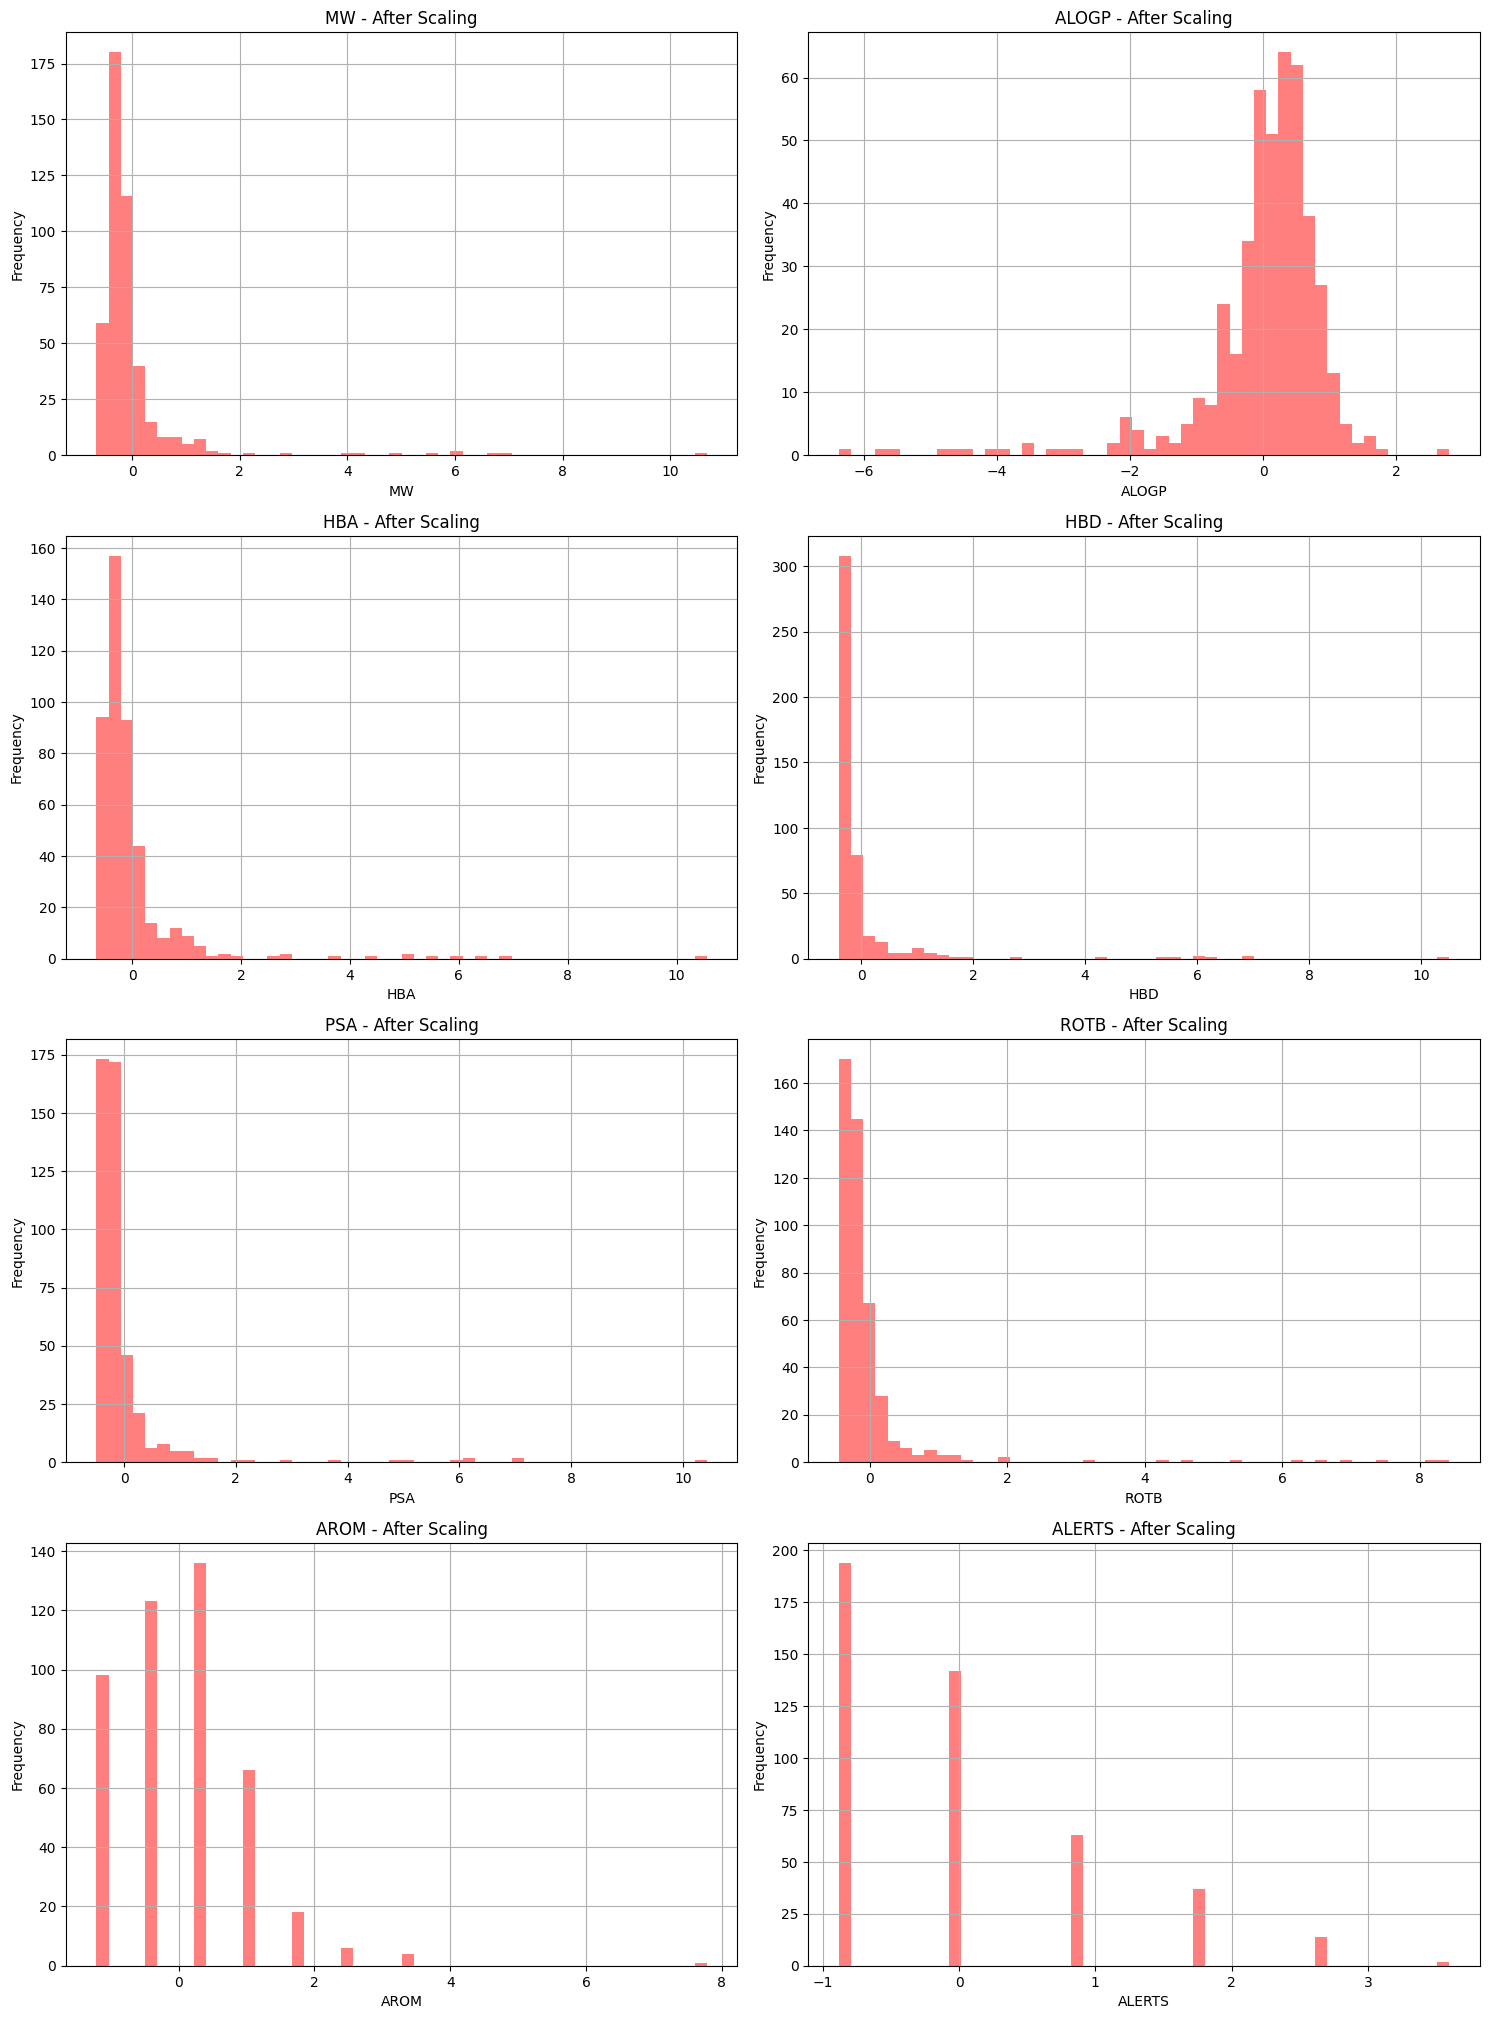

In [3]:
import matplotlib.pyplot as plt

# Function to plot histograms of descriptors
def plot_histograms(before_scaling_df, after_scaling_df):
    num_cols = before_scaling_df.shape[1]

    # Plot histograms for descriptors before scaling
    plt.figure(figsize=(15, 5 * num_cols))
    for i, col in enumerate(before_scaling_df.columns):
        plt.subplot(num_cols, 2, i + 1)
        plt.hist(before_scaling_df[col], bins=50, alpha=0.5, color='b')
        plt.title(f'{col} - Before Scaling')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot histograms for descriptors after scaling
    plt.figure(figsize=(15, 5 * num_cols))
    for i, col in enumerate(after_scaling_df.columns):
        plt.subplot(num_cols, 2, i + 1)
        plt.hist(after_scaling_df[col], bins=50, alpha=0.5, color='r')
        plt.title(f'{col} - After Scaling')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Load your dataset
test_dataset_filepath = os.path.join(DATAPATH, 'test.csv')
test_df = pd.read_csv(test_dataset_filepath)

train_dataset_filepath = os.path.join(DATAPATH, 'train.csv')
train_df = pd.read_csv(train_dataset_filepath)

# Preprocess the data
processed_test_data = preprocess_data(test_df)
processed_train_data = preprocess_data(train_df)

# Extract QED descriptors before and after scaling
qed_before_scaling = qed_calculation(test_df['smiles'])
qed_after_scaling = scale_qed(qed_before_scaling)

# Plot histograms of descriptors
plot_histograms(qed_before_scaling, qed_after_scaling)


In [4]:
print(processed_test_data)

       0    1    2    3    4    5    6    7    8    9  ...  1023        MW  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0 -0.031682   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0 -0.372504   
2    0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   0.0  1.197573   
3    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0 -0.359417   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0 -0.391879   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...       ...   
447  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.015372   
448  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.054410   
449  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.103049   
450  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.749251   
451  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0 -0.402110   

        ALOGP       HBA       HBD       PSA      ROTB      AROM

In [5]:
print(processed_train_data)

        0    1    2    3    4    5    6    7    8    9  ...  1023        MW  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0 -0.769322   
1     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  ...   0.0 -0.022689   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   0.0 -0.450835   
3     0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  ...   0.0  0.266304   
4     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   0.0 -0.478688   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...       ...   
1393  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   0.0  3.601285   
1394  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  2.958710   
1395  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  1.102378   
1396  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.990976   
1397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0  0.340709   

         ALOGP       HBA       HBD       PSA      R

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       268
           1       0.82      0.95      0.88       184

    accuracy                           0.90       452
   macro avg       0.89      0.90      0.89       452
weighted avg       0.91      0.90      0.90       452



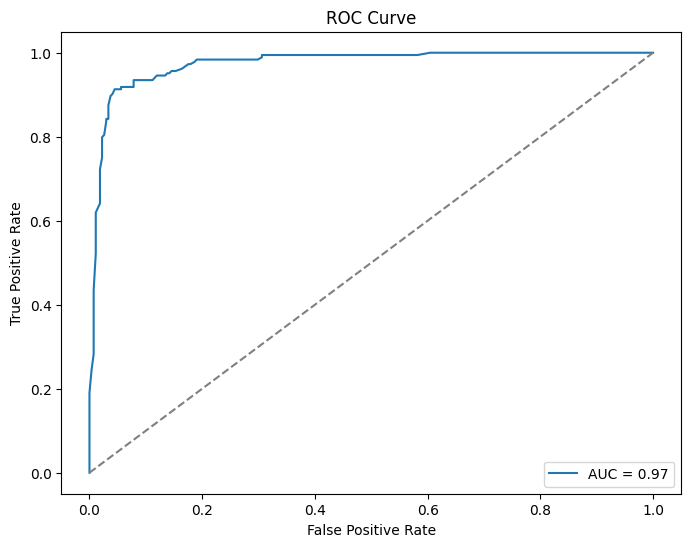

['../../checkpoints/random_forest_model.pkl']

In [6]:
## Random forest classifier model
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Split features and target variable
X_train = processed_train_data.drop(columns=['toxicity'])
y_train = processed_train_data['toxicity']
X_test = processed_test_data.drop(columns=['toxicity'])
y_test = processed_test_data['toxicity']

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Convert feature names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# AUC-ROC Curve
y_prob = rf_classifier.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Save the trained model to a file
joblib.dump(rf_classifier, '../../checkpoints/random_forest_model.pkl')